# NB04: Lab-Field Concordance & NMDC Validation

**Requires BERDL JupyterHub** — `get_spark_session()` is only available in JupyterHub kernels.

## Purpose

Test whether dark genes' lab fitness conditions predict the environmental contexts where
they appear in nature. Two independent tests:

1. **Lab-field concordance**: Pre-registered mapping from FB experiment groups to expected
   environmental categories, then test if carrier genomes are enriched in the predicted environments
2. **NMDC independent validation**: For taxa carrying dark genes, check if their abundance in
   NMDC metagenomic samples correlates with abiotic variables matching the lab fitness conditions

## Inputs

- `data/dark_genes_only.tsv` from NB01
- `data/carrier_noncarrier_tests.tsv` from NB03
- `data/carrier_genome_map.tsv` from NB03
- `data/biogeographic_profiles.tsv` from NB03

## Outputs

- `data/lab_field_concordance.tsv` — per-cluster concordance test results
- `data/nmdc_validation.tsv` — NMDC abiotic correlation results
- `figures/fig11_concordance_matrix.png`
- `figures/fig12_nmdc_correlations.png`

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Path setup
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
else:
    PROJECT_DIR = os.getcwd()
    _d = PROJECT_DIR
    while _d != '/':
        if os.path.exists(os.path.join(_d, 'PROJECT.md')):
            break
        _d = os.path.dirname(_d)

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

spark = get_spark_session()
print(f'Project dir: {PROJECT_DIR}')

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter


## Section 1: Pre-Registered Condition-Environment Mapping

Define the mapping from FB experiment condition classes to expected environmental
categories **before** looking at the biogeographic data. This prevents post-hoc
cherry-picking of associations.

In [2]:
# Pre-registered mapping: FB condition class -> expected environment categories
# Each condition class maps to one or more env_category values from NB03's classification
CONDITION_ENV_MAP = {
    'stress': {
        'expected_envs': ['contaminated', 'soil_sediment', 'wastewater_engineered'],
        'description': 'Stress conditions (metals, oxidative, osmotic) -> contaminated/variable environments',
        'nmdc_abiotic': [],  # stress is heterogeneous, no single abiotic variable
    },
    'carbon source': {
        'expected_envs': ['soil_sediment', 'freshwater', 'plant_associated'],
        'description': 'Carbon utilization -> carbon-rich environments (soil, freshwater, rhizosphere)',
        'nmdc_abiotic': ['annotations_tot_org_carb_has_numeric_value',
                         'annotations_diss_org_carb_has_numeric_value'],
    },
    'nitrogen source': {
        'expected_envs': ['soil_sediment', 'freshwater', 'wastewater_engineered'],
        'description': 'Nitrogen utilization -> nitrogen-variable environments',
        'nmdc_abiotic': ['annotations_tot_nitro_content_has_numeric_value',
                         'annotations_ammonium_has_numeric_value',
                         'annotations_ammonium_nitrogen_has_numeric_value'],
    },
    'pH': {
        'expected_envs': ['soil_sediment', 'extreme', 'freshwater'],
        'description': 'pH stress -> pH-variable environments',
        'nmdc_abiotic': ['annotations_ph'],
    },
    'motility': {
        'expected_envs': ['soil_sediment', 'freshwater', 'plant_associated'],
        'description': 'Motility -> structured environments requiring chemotaxis',
        'nmdc_abiotic': [],
    },
    'anaerobic': {
        'expected_envs': ['soil_sediment', 'freshwater', 'animal_associated'],
        'description': 'Anaerobic growth -> low-oxygen environments',
        'nmdc_abiotic': ['annotations_diss_oxygen_has_numeric_value'],
    },
}

print('Pre-registered condition-environment mapping:')
for cond, info in CONDITION_ENV_MAP.items():
    print(f'  {cond} -> {info["expected_envs"]}')
    if info['nmdc_abiotic']:
        print(f'    NMDC abiotic: {info["nmdc_abiotic"]}')

Pre-registered condition-environment mapping:
  stress -> ['contaminated', 'soil_sediment', 'wastewater_engineered']
  carbon source -> ['soil_sediment', 'freshwater', 'plant_associated']
    NMDC abiotic: ['annotations_tot_org_carb_has_numeric_value', 'annotations_diss_org_carb_has_numeric_value']
  nitrogen source -> ['soil_sediment', 'freshwater', 'wastewater_engineered']
    NMDC abiotic: ['annotations_tot_nitro_content_has_numeric_value', 'annotations_ammonium_has_numeric_value', 'annotations_ammonium_nitrogen_has_numeric_value']
  pH -> ['soil_sediment', 'extreme', 'freshwater']
    NMDC abiotic: ['annotations_ph']
  motility -> ['soil_sediment', 'freshwater', 'plant_associated']
  anaerobic -> ['soil_sediment', 'freshwater', 'animal_associated']
    NMDC abiotic: ['annotations_diss_oxygen_has_numeric_value']


In [3]:
# Load NB03 results
dark = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_only.tsv'), sep='\t', low_memory=False)
carrier_tests = pd.read_csv(os.path.join(DATA_DIR, 'carrier_noncarrier_tests.tsv'), sep='\t')
carrier_map = pd.read_csv(os.path.join(DATA_DIR, 'carrier_genome_map.tsv'), sep='\t')
profiles = pd.read_csv(os.path.join(DATA_DIR, 'biogeographic_profiles.tsv'), sep='\t')

print(f'Carrier test results: {len(carrier_tests)} clusters')
print(f'Carrier genome map: {len(carrier_map):,} pairs')
print(f'Species profiles: {len(profiles)} species')

# Filter to clusters with condition class in our pre-registered mapping
mapped_conditions = list(CONDITION_ENV_MAP.keys())
concordance_clusters = carrier_tests[
    carrier_tests['top_condition_class'].isin(mapped_conditions)
].copy()
print(f'\nClusters with mapped condition class: {len(concordance_clusters)}')
print(concordance_clusters['top_condition_class'].value_counts().to_string())

Carrier test results: 151 clusters
Carrier genome map: 8,139 pairs
Species profiles: 31 species

Clusters with mapped condition class: 121
top_condition_class
stress             65
carbon source      38
nitrogen source    11
pH                  4
motility            2
anaerobic           1


## Section 2: Lab-Field Concordance Test

For each cluster with a mapped condition class AND environment data for carriers,
test whether carriers are enriched in the predicted environment categories.

In [4]:
# Re-extract environment data for carrier and non-carrier genomes
# We need the raw env categories per genome, not just the top carrier env from NB03

# Load all genomes in target species (from NB03 approach)
target_species = concordance_clusters['gtdb_species_clade_id'].unique().tolist()
species_sdf = spark.createDataFrame(
    [(str(s),) for s in target_species],
    ['gtdb_species_clade_id']
)
species_sdf.createOrReplaceTempView('concordance_species')

all_genomes = spark.sql("""
    SELECT g.genome_id, g.gtdb_species_clade_id, g.ncbi_biosample_id
    FROM kbase_ke_pangenome.genome g
    JOIN concordance_species cs ON g.gtdb_species_clade_id = cs.gtdb_species_clade_id
""").toPandas()

# Pivot NCBI env for these genomes
genome_ids_sdf = spark.createDataFrame(
    [(str(gid), str(bs)) for gid, bs in zip(
        all_genomes['genome_id'].tolist(),
        all_genomes['ncbi_biosample_id'].fillna('').tolist()
    ) if bs],
    ['genome_id', 'accession']
)
genome_ids_sdf.createOrReplaceTempView('concordance_genomes')

env_data = spark.sql("""
    SELECT cg.genome_id,
           MAX(CASE WHEN ne.harmonized_name = 'isolation_source' THEN ne.content END) as isolation_source,
           MAX(CASE WHEN ne.harmonized_name = 'env_broad_scale' THEN ne.content END) as env_broad_scale,
           MAX(CASE WHEN ne.harmonized_name = 'host' THEN ne.content END) as host
    FROM concordance_genomes cg
    JOIN kbase_ke_pangenome.ncbi_env ne ON cg.accession = ne.accession
    GROUP BY cg.genome_id
""").toPandas()

print(f'Env data for {len(env_data):,} genomes in {len(target_species)} species')

Env data for 1,131 genomes in 10 species


In [5]:
# Classify environments (same function as NB03)
def classify_environment(row):
    source = str(row.get('isolation_source', '')).lower()
    host = str(row.get('host', '')).lower()
    if any(kw in source for kw in ['contaminated', 'polluted', 'mining', 'acid mine',
                                    'industrial', 'heavy metal', 'uranium', 'chromium']):
        return 'contaminated'
    if any(kw in source for kw in ['blood', 'sputum', 'urine', 'wound', 'clinical',
                                    'patient', 'hospital', 'human']):
        return 'human_clinical'
    if 'homo sapiens' in host or 'human' in host:
        return 'human_associated'
    if any(kw in source for kw in ['animal', 'bovine', 'chicken', 'pig', 'cattle',
                                    'poultry', 'feces', 'gut', 'intestin', 'rumen']):
        return 'animal_associated'
    if any(kw in source for kw in ['soil', 'rhizosphere', 'root', 'compost', 'peat',
                                    'agricultural', 'sediment']):
        return 'soil_sediment'
    if any(kw in source for kw in ['marine', 'ocean', 'sea', 'seawater', 'coastal',
                                    'saline', 'brackish', 'salt', 'brine', 'hypersaline']):
        return 'marine_saline'
    if any(kw in source for kw in ['freshwater', 'lake', 'river', 'pond', 'stream',
                                    'groundwater', 'spring', 'aquifer']):
        return 'freshwater'
    if any(kw in source for kw in ['plant', 'leaf', 'stem', 'flower', 'seed',
                                    'phyllosphere', 'endophyte']):
        return 'plant_associated'
    if any(kw in source for kw in ['wastewater', 'sewage', 'activated sludge',
                                    'bioreactor', 'ferment']):
        return 'wastewater_engineered'
    if any(kw in source for kw in ['hot spring', 'hydrothermal', 'volcanic',
                                    'permafrost', 'acidic', 'alkaline']):
        return 'extreme'
    return 'other_unknown'

env_data['env_category'] = env_data.apply(classify_environment, axis=1)
env_lookup = env_data.set_index('genome_id')['env_category'].to_dict()
print(f'Environment lookup: {len(env_lookup):,} genomes')
print(env_data['env_category'].value_counts().to_string())

Environment lookup: 1,131 genomes
env_category
other_unknown            442
human_associated         427
human_clinical           142
soil_sediment             37
animal_associated         25
plant_associated          23
freshwater                14
wastewater_engineered     12
marine_saline              6
contaminated               3


In [6]:
# Build carrier sets from carrier_map
carrier_sets = carrier_map.groupby('gene_cluster_id')['genome_id'].apply(set).to_dict()
genomes_per_species = all_genomes.groupby('gtdb_species_clade_id')['genome_id'].apply(set).to_dict()

# Run concordance test for each cluster
concordance_results = []

for _, row in concordance_clusters.iterrows():
    cid = row['gene_cluster_id']
    sid = row['gtdb_species_clade_id']
    cond_class = row['top_condition_class']
    expected_envs = CONDITION_ENV_MAP[cond_class]['expected_envs']
    
    all_gids = genomes_per_species.get(sid, set())
    carrier_gids = carrier_sets.get(cid, set()) & all_gids
    noncarrier_gids = all_gids - carrier_gids
    
    # Get env categories for carriers and non-carriers
    carrier_envs = [env_lookup.get(g) for g in carrier_gids if g in env_lookup]
    noncarrier_envs = [env_lookup.get(g) for g in noncarrier_gids if g in env_lookup]
    
    if len(carrier_envs) < 3 or len(noncarrier_envs) < 3:
        continue
    
    # Count carriers in expected vs non-expected environments
    a = sum(1 for e in carrier_envs if e in expected_envs)  # carrier + expected
    b = sum(1 for e in carrier_envs if e not in expected_envs)  # carrier + not expected
    c = sum(1 for e in noncarrier_envs if e in expected_envs)  # non-carrier + expected
    d = sum(1 for e in noncarrier_envs if e not in expected_envs)  # non-carrier + not expected
    
    if a + c == 0:  # no genomes in expected environments at all
        continue
    
    odds_ratio, p_val = stats.fisher_exact([[a, b], [c, d]])
    
    concordance_results.append({
        'gene_cluster_id': cid,
        'gtdb_species_clade_id': sid,
        'orgId': row.get('orgId', ''),
        'locusId': row.get('locusId', ''),
        'desc': row.get('desc', ''),
        'top_condition_class': cond_class,
        'max_abs_fit': row.get('max_abs_fit', np.nan),
        'expected_envs': '|'.join(expected_envs),
        'n_carriers': len(carrier_envs),
        'n_noncarriers': len(noncarrier_envs),
        'carrier_in_expected': a,
        'carrier_pct_expected': a / (a + b) * 100 if (a + b) > 0 else 0,
        'noncarrier_in_expected': c,
        'noncarrier_pct_expected': c / (c + d) * 100 if (c + d) > 0 else 0,
        'odds_ratio': odds_ratio,
        'p_value': p_val,
        'is_concordant': a / (a + b) > c / (c + d) if (a + b) > 0 and (c + d) > 0 else False,
    })

conc_df = pd.DataFrame(concordance_results)
print(f'Concordance tests completed: {len(conc_df)} clusters')
print(f'  By condition class:')
print(conc_df['top_condition_class'].value_counts().to_string())

Concordance tests completed: 47 clusters
  By condition class:
top_condition_class
carbon source      23
nitrogen source     9
stress              8
pH                  4
motility            2
anaerobic           1


In [7]:
# Apply BH-FDR correction
from statsmodels.stats.multitest import multipletests

if len(conc_df) > 0:
    _, fdr, _, _ = multipletests(conc_df['p_value'], method='fdr_bh')
    conc_df['fdr'] = fdr
    
    n_sig = (fdr < 0.05).sum()
    n_concordant = conc_df['is_concordant'].sum()
    n_sig_concordant = ((fdr < 0.05) & conc_df['is_concordant']).sum()
    
    print(f'Concordance summary:')
    print(f'  Total tested: {len(conc_df)}')
    print(f'  Concordant (carrier enriched in expected env): {n_concordant} ({n_concordant/len(conc_df)*100:.1f}%)')
    print(f'  Significant (FDR < 0.05): {n_sig}')
    print(f'  Significant AND concordant: {n_sig_concordant}')
    
    # Per condition class
    print(f'\nPer condition class:')
    for cond in conc_df['top_condition_class'].unique():
        sub = conc_df[conc_df['top_condition_class'] == cond]
        n_c = sub['is_concordant'].sum()
        n_s = (sub['fdr'] < 0.05).sum()
        print(f'  {cond}: {len(sub)} tested, {n_c} concordant ({n_c/len(sub)*100:.0f}%), {n_s} sig')
else:
    print('No clusters could be tested for concordance')
    conc_df['fdr'] = np.nan

Concordance summary:
  Total tested: 47
  Concordant (carrier enriched in expected env): 29 (61.7%)
  Significant (FDR < 0.05): 1
  Significant AND concordant: 0

Per condition class:
  carbon source: 23 tested, 15 concordant (65%), 0 sig
  stress: 8 tested, 2 concordant (25%), 1 sig
  nitrogen source: 9 tested, 7 concordant (78%), 0 sig
  pH: 4 tested, 4 concordant (100%), 0 sig
  anaerobic: 1 tested, 1 concordant (100%), 0 sig
  motility: 2 tested, 0 concordant (0%), 0 sig


In [8]:
# Show top concordant results
if len(conc_df) > 0:
    sig_conc = conc_df[(conc_df['fdr'] < 0.2) & conc_df['is_concordant']].sort_values('odds_ratio', ascending=False)
    if len(sig_conc) > 0:
        print(f'Significant concordant clusters (FDR < 0.2): {len(sig_conc)}')
        cols = ['gene_cluster_id', 'orgId', 'locusId', 'desc', 'top_condition_class',
                'max_abs_fit', 'expected_envs', 'carrier_pct_expected', 'noncarrier_pct_expected',
                'odds_ratio', 'p_value', 'fdr']
        print(sig_conc[cols].head(20).to_string())
    else:
        print('No significant concordant clusters at FDR < 0.2')
        print('\nTop 10 by odds ratio (concordant only):')
        top = conc_df[conc_df['is_concordant']].sort_values('odds_ratio', ascending=False)
        cols = ['gene_cluster_id', 'orgId', 'desc', 'top_condition_class',
                'carrier_pct_expected', 'noncarrier_pct_expected', 'odds_ratio', 'p_value']
        print(top[cols].head(10).to_string())

Significant concordant clusters (FDR < 0.2): 6
            gene_cluster_id           orgId        locusId                  desc top_condition_class  max_abs_fit                                   expected_envs  carrier_pct_expected  noncarrier_pct_expected  odds_ratio   p_value       fdr
24  NZ_JACVAH010000015.1_20  pseudo5_N2C3_1    AO356_12450  hypothetical protein       carbon source     2.076086       soil_sediment|freshwater|plant_associated             62.500000                 0.000000         inf  0.009050  0.092663
23  NZ_JACVAH010000006.1_10  pseudo5_N2C3_1    AO356_25185  hypothetical protein           anaerobic     2.723784      soil_sediment|freshwater|animal_associated             55.555556                 0.000000         inf  0.029412  0.178201
38     NZ_PPRZ01000025.1_37  pseudo5_N2C3_1    AO356_24150  hypothetical protein     nitrogen source     3.012796  soil_sediment|freshwater|wastewater_engineered             55.555556                 0.000000         inf  0.029412

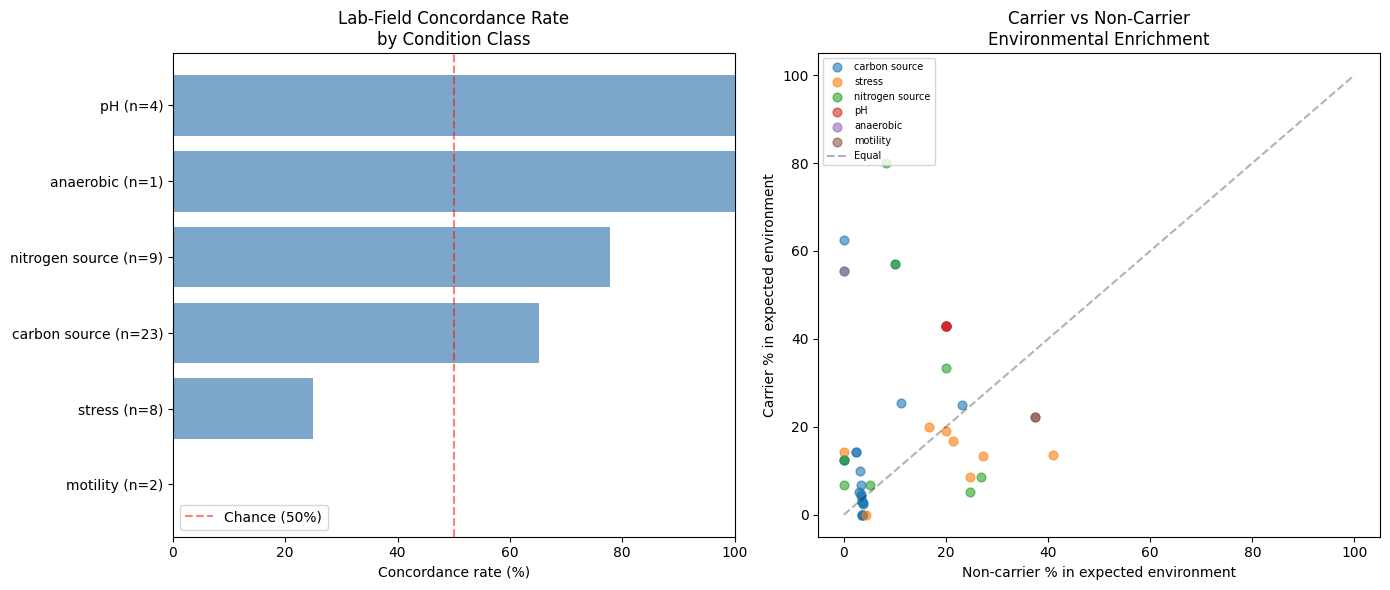

Saved fig11_concordance_matrix.png


In [9]:
# Figure 11: Concordance matrix — condition class vs observed enrichment direction
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Concordance rate by condition class
ax = axes[0]
if len(conc_df) > 0:
    cond_summary = conc_df.groupby('top_condition_class').agg(
        n_tested=('gene_cluster_id', 'count'),
        n_concordant=('is_concordant', 'sum'),
        n_significant=('fdr', lambda x: (x < 0.05).sum()),
        mean_carrier_pct=('carrier_pct_expected', 'mean'),
        mean_noncarrier_pct=('noncarrier_pct_expected', 'mean'),
    ).reset_index()
    cond_summary['concordance_rate'] = cond_summary['n_concordant'] / cond_summary['n_tested'] * 100
    cond_summary = cond_summary.sort_values('concordance_rate', ascending=True)
    
    y_pos = range(len(cond_summary))
    bars = ax.barh(y_pos, cond_summary['concordance_rate'], color='steelblue', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{c} (n={n})" for c, n in zip(cond_summary['top_condition_class'], cond_summary['n_tested'])])
    ax.set_xlabel('Concordance rate (%)')
    ax.set_title('Lab-Field Concordance Rate\nby Condition Class')
    ax.axvline(50, color='red', linestyle='--', alpha=0.5, label='Chance (50%)')
    ax.legend()
    ax.set_xlim(0, 100)

# Panel B: Carrier vs non-carrier % in expected environment
ax = axes[1]
if len(conc_df) > 0:
    for cond in conc_df['top_condition_class'].unique():
        sub = conc_df[conc_df['top_condition_class'] == cond]
        ax.scatter(sub['noncarrier_pct_expected'], sub['carrier_pct_expected'],
                  label=cond, alpha=0.6, s=40)
    
    ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Equal')
    ax.set_xlabel('Non-carrier % in expected environment')
    ax.set_ylabel('Carrier % in expected environment')
    ax.set_title('Carrier vs Non-Carrier\nEnvironmental Enrichment')
    ax.legend(fontsize=7, loc='upper left')
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig11_concordance_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig11_concordance_matrix.png')

## Section 3: NMDC Independent Validation

Use NMDC metagenomic data as an independent check. For taxa that carry dark genes
in the pangenome, we infer their abundance in NMDC samples via the taxonomy profile,
then correlate with abiotic measurements.

This is **community-level** validation at **genus** resolution — not gene-level.
Results should be framed as "consistent with" or "independently corroborated by".

In [10]:
# Load NMDC tables
print('Loading NMDC tables...')
tax_features = spark.sql("SELECT * FROM nmdc_arkin.taxonomy_features").toPandas()
print(f'  taxonomy_features: {tax_features.shape[0]} samples x {tax_features.shape[1]} columns')

abiotic = spark.sql("SELECT * FROM nmdc_arkin.abiotic_features").toPandas()
print(f'  abiotic_features: {abiotic.shape[0]} samples x {abiotic.shape[1]} columns')

tax_dim = spark.sql("SELECT * FROM nmdc_arkin.taxonomy_dim").toPandas()
print(f'  taxonomy_dim: {tax_dim.shape[0]} taxa')

# Identify taxon columns (numeric taxids as column names)
taxon_cols = [c for c in tax_features.columns if c != 'sample_id' and c.isdigit()]
print(f'  Taxon columns: {len(taxon_cols)}')

# Overlap between taxonomy and abiotic samples
shared_samples = set(tax_features['sample_id']) & set(abiotic['sample_id'])
print(f'  Samples with both taxonomy + abiotic: {len(shared_samples)}')

Loading NMDC tables...


  taxonomy_features: 6365 samples x 3493 columns


  abiotic_features: 13847 samples x 22 columns


  taxonomy_dim: 2594787 taxa
  Taxon columns: 3492
  Samples with both taxonomy + abiotic: 6365


In [11]:
# ── FIXED: Use proven two-tier genus mapping from prophage_ecology ──
# The previous approach failed because gtdb_species_clade_id format
# (s__Genus_species--RS_GCF_xxx) doesn't match gtdb_taxonomy_r214v1.species.
# Instead, use gtdb_metadata.gtdb_taxonomy to extract genera, and map NMDC
# taxon columns via ncbi_taxid → GTDB genus (Tier 1) + taxonomy_dim (Tier 2).

# Step 1: Extract carrier genera directly from species clade IDs
import re

carrier_species = concordance_clusters['gtdb_species_clade_id'].unique()
species_genus_map = {}
for sp in carrier_species:
    # Format: s__Genus_species--RS_GCF_xxx → extract Genus
    m = re.match(r's__(\w+?)_', str(sp))
    if m:
        species_genus_map[sp] = m.group(1)

carrier_genera = set(species_genus_map.values())
print(f'Carrier species: {len(carrier_species)}')
print(f'Carrier genera (from clade IDs): {len(carrier_genera)}')
print(f'  Genera: {", ".join(sorted(carrier_genera))}')

# Step 2: Build Tier 1 mapping — ncbi_taxid → GTDB genus via gtdb_metadata
ncbi_to_gtdb = spark.sql("""
    SELECT DISTINCT
        CAST(m.ncbi_species_taxid AS INT) as ncbi_taxid,
        REGEXP_EXTRACT(m.gtdb_taxonomy, 'g__([^;]+)', 1) AS gtdb_genus
    FROM kbase_ke_pangenome.gtdb_metadata m
    WHERE m.gtdb_taxonomy IS NOT NULL
      AND REGEXP_EXTRACT(m.gtdb_taxonomy, 'g__([^;]+)', 1) != ''
    UNION
    SELECT DISTINCT
        CAST(m.ncbi_taxid AS INT) as ncbi_taxid,
        REGEXP_EXTRACT(m.gtdb_taxonomy, 'g__([^;]+)', 1) AS gtdb_genus
    FROM kbase_ke_pangenome.gtdb_metadata m
    WHERE m.gtdb_taxonomy IS NOT NULL
      AND REGEXP_EXTRACT(m.gtdb_taxonomy, 'g__([^;]+)', 1) != ''
""").toPandas()

# For taxids mapping to multiple genera, take the most common
ncbi_genus_map = ncbi_to_gtdb.groupby('ncbi_taxid')['gtdb_genus'].agg(
    lambda x: x.value_counts().index[0]
).to_dict()
print(f'\nTier 1 ncbi_taxid → genus mapping: {len(ncbi_genus_map):,} taxids')

# Build Tier 1 taxon column mapping
taxid_to_genus = {}
tier1_hits = 0
for col_id in taxon_cols:
    try:
        tid = int(col_id)
    except (ValueError, TypeError):
        continue
    if tid in ncbi_genus_map:
        taxid_to_genus[col_id] = ncbi_genus_map[tid]
        tier1_hits += 1

print(f'Tier 1 matches: {tier1_hits} / {len(taxon_cols)} taxon columns')

# Tier 2 fallback: use taxonomy_dim for unmatched columns
carrier_genera_lower = {g.lower() for g in carrier_genera}
tier2_hits = 0
for col_id in taxon_cols:
    if col_id in taxid_to_genus:
        continue
    try:
        tid = int(col_id)
    except (ValueError, TypeError):
        continue
    matches = tax_dim[tax_dim['taxid'] == tid]
    if len(matches) > 0:
        genus = str(matches.iloc[0]['genus']).strip()
        if genus and genus.lower() not in ('unclassified', 'nan', ''):
            taxid_to_genus[col_id] = genus
            tier2_hits += 1

print(f'Tier 2 matches: {tier2_hits} additional columns')
print(f'Total mapped: {len(taxid_to_genus)} / {len(taxon_cols)} ({len(taxid_to_genus)/len(taxon_cols)*100:.1f}%)')

# Step 3: Find NMDC taxon columns matching carrier genera
matched_cols = {}  # genus → list of taxon column names
for col_id, genus in taxid_to_genus.items():
    if genus in carrier_genera:
        if genus not in matched_cols:
            matched_cols[genus] = []
        matched_cols[genus].append(col_id)

print(f'\nMatched carrier genera in NMDC: {len(matched_cols)} / {len(carrier_genera)}')
n_matched_cols = sum(len(v) for v in matched_cols.values())
print(f'Total matched taxon columns: {n_matched_cols}')
if matched_cols:
    print(f'Matched genera: {", ".join(sorted(matched_cols.keys()))}')

Carrier species: 10
Carrier genera (from clade IDs): 6
  Genera: Bacteroides, Klebsiella, Methanococcus, Phaeobacter, Pseudomonas, Sphingomonas



Tier 1 ncbi_taxid → genus mapping: 61,207 taxids
Tier 1 matches: 2336 / 3492 taxon columns


Tier 2 matches: 1069 additional columns
Total mapped: 3405 / 3492 (97.5%)

Matched carrier genera in NMDC: 5 / 6
Total matched taxon columns: 47
Matched genera: Bacteroides, Klebsiella, Phaeobacter, Pseudomonas, Sphingomonas


In [12]:
# (Genus mapping is now complete from cell above — Tier 1 + Tier 2)
# Summary of mapping pipeline:
print('=== NMDC Genus Mapping Summary ===')
print(f'Carrier genera from dark gene species: {len(carrier_genera)}')
print(f'Total NMDC taxon columns: {len(taxon_cols)}')
print(f'Tier 1 (gtdb_metadata): {tier1_hits} columns mapped')
print(f'Tier 2 (taxonomy_dim): {tier2_hits} additional columns mapped')
print(f'Total mapped: {len(taxid_to_genus)} / {len(taxon_cols)} ({len(taxid_to_genus)/len(taxon_cols)*100:.1f}%)')
print(f'Matched to carrier genera: {len(matched_cols)} genera, {n_matched_cols} taxon columns')

=== NMDC Genus Mapping Summary ===
Carrier genera from dark gene species: 6
Total NMDC taxon columns: 3492
Tier 1 (gtdb_metadata): 2336 columns mapped
Tier 2 (taxonomy_dim): 1069 additional columns mapped
Total mapped: 3405 / 3492 (97.5%)
Matched to carrier genera: 5 genera, 47 taxon columns


In [13]:
# Compute per-sample dark gene carrier scores
# For each NMDC sample, weight taxon abundances by genus-level dark gene burden
# (analogous to prophage_ecology NB05 per-sample scoring)

# Step 1: Build genus-level dark gene burden from concordance_clusters
cluster_genus = concordance_clusters[
    ['gene_cluster_id', 'gtdb_species_clade_id', 'top_condition_class']
].copy()
cluster_genus['genus'] = cluster_genus['gtdb_species_clade_id'].map(species_genus_map)

# Overall burden: number of dark gene clusters per genus
genus_burden = cluster_genus.groupby('genus')['gene_cluster_id'].nunique().to_dict()

# Per-condition burden
genus_cond_burden = {}
for cond in CONDITION_ENV_MAP:
    sub = cluster_genus[cluster_genus['top_condition_class'] == cond]
    genus_cond_burden[cond] = sub.groupby('genus')['gene_cluster_id'].nunique().to_dict()

print('Genus-level dark gene burden:')
for g in sorted(genus_burden.keys()):
    parts = [f'{c}:{genus_cond_burden[c][g]}'
             for c in CONDITION_ENV_MAP if g in genus_cond_burden[c]]
    print(f'  {g}: {genus_burden[g]} clusters ({", ".join(parts)})')

# Step 2: Map taxon columns to burden weights
col_overall_weight = {}
col_cond_weights = {cond: {} for cond in CONDITION_ENV_MAP}

for genus, col_ids in matched_cols.items():
    for col_id in col_ids:
        col_overall_weight[col_id] = genus_burden.get(genus, 0)
        for cond in CONDITION_ENV_MAP:
            w = genus_cond_burden[cond].get(genus, 0)
            if w > 0:
                col_cond_weights[cond][col_id] = w

matched_col_ids = list(col_overall_weight.keys())
print(f'\nMatched taxon columns with burden weights: {len(matched_col_ids)}')

if len(matched_col_ids) == 0:
    print('WARNING: No matched columns — NMDC validation will be empty')
    tax_shared = pd.DataFrame({'sample_id': tax_features['sample_id'],
                                'dark_carrier_abundance': 0.0})
    for cond in CONDITION_ENV_MAP:
        tax_shared[f'score_{cond.replace(" ", "_")}'] = 0.0
    abiotic_shared = abiotic[abiotic['sample_id'].isin(shared_samples)].copy()
else:
    # Step 3: Vectorized scoring via matrix multiplication
    overall_weights = np.array([col_overall_weight[c] for c in matched_col_ids])

    matched_matrix = tax_features[matched_col_ids].apply(
        pd.to_numeric, errors='coerce').fillna(0).values

    dark_carrier_abundance = matched_matrix @ overall_weights
    matched_abundance = matched_matrix.sum(axis=1)

    # Total abundance across ALL taxon columns
    all_numeric = tax_features[taxon_cols].apply(
        pd.to_numeric, errors='coerce').fillna(0).values
    total_abundance = all_numeric.sum(axis=1)

    # Per-condition scores
    cond_score_arrays = {}
    for cond in CONDITION_ENV_MAP:
        cond_col_ids = [c for c in matched_col_ids if c in col_cond_weights[cond]]
        if cond_col_ids:
            cond_w = np.array([col_cond_weights[cond][c] for c in cond_col_ids])
            cond_m = tax_features[cond_col_ids].apply(
                pd.to_numeric, errors='coerce').fillna(0).values
            cond_score_arrays[cond] = cond_m @ cond_w
        else:
            cond_score_arrays[cond] = np.zeros(len(tax_features))

    # Build result DataFrame
    tax_shared = pd.DataFrame({
        'sample_id': tax_features['sample_id'],
        'dark_carrier_abundance': dark_carrier_abundance,
        'matched_abundance': matched_abundance,
        'total_abundance': total_abundance,
        'pct_matched': np.where(total_abundance > 0,
                                 matched_abundance / total_abundance * 100, 0),
    })
    for cond in CONDITION_ENV_MAP:
        tax_shared[f'score_{cond.replace(" ", "_")}'] = cond_score_arrays[cond]

    abiotic_shared = abiotic[abiotic['sample_id'].isin(shared_samples)].copy()

    print(f'\nScored {len(tax_shared)} NMDC samples')
    print(f'  Non-zero dark_carrier_abundance: '
          f'{(tax_shared["dark_carrier_abundance"] > 0).sum()} / {len(tax_shared)}')
    print(f'  Median pct_matched: {tax_shared["pct_matched"].median():.1f}%')
    for cond in CONDITION_ENV_MAP:
        col = f'score_{cond.replace(" ", "_")}'
        nz = (tax_shared[col] > 0).sum()
        print(f'  {col}: {nz} non-zero samples')

Genus-level dark gene burden:
  Bacteroides: 45 clusters (stress:29, carbon source:14, nitrogen source:2)
  Klebsiella: 17 clusters (stress:1, carbon source:15, nitrogen source:1)
  Methanococcus: 2 clusters (nitrogen source:2)
  Phaeobacter: 1 clusters (stress:1)
  Pseudomonas: 54 clusters (stress:33, carbon source:8, nitrogen source:6, pH:4, motility:2, anaerobic:1)
  Sphingomonas: 2 clusters (stress:1, carbon source:1)

Matched taxon columns with burden weights: 47



Scored 6365 NMDC samples
  Non-zero dark_carrier_abundance: 1421 / 6365
  Median pct_matched: 0.0%
  score_stress: 1433 non-zero samples
  score_carbon_source: 1394 non-zero samples
  score_nitrogen_source: 1477 non-zero samples
  score_pH: 1490 non-zero samples
  score_motility: 1490 non-zero samples
  score_anaerobic: 1490 non-zero samples


In [14]:
# Correlate dark carrier abundance with abiotic variables
# Merge taxonomy scores with abiotic measurements
merged = tax_shared[['sample_id', 'dark_carrier_abundance'] +
                     [c for c in tax_shared.columns if c.startswith('score_')]].merge(
    abiotic_shared, on='sample_id', how='inner'
)
print(f'Merged samples for correlation: {len(merged)}')

# Get abiotic column names
abiotic_cols = [c for c in abiotic_shared.columns if c.startswith('annotations_')]
score_cols = ['dark_carrier_abundance'] + [c for c in tax_shared.columns if c.startswith('score_')]

# Correlate each score with each abiotic variable
nmdc_results = []

for score_col in score_cols:
    for abiotic_col in abiotic_cols:
        score_vals = pd.to_numeric(merged[score_col], errors='coerce')
        abiotic_vals = pd.to_numeric(merged[abiotic_col], errors='coerce')
        
        valid = score_vals.notna() & abiotic_vals.notna() & (abiotic_vals != 0)
        n_valid = valid.sum()
        
        if n_valid >= 30:
            rho, p = stats.spearmanr(score_vals[valid], abiotic_vals[valid])
            nmdc_results.append({
                'score_type': score_col,
                'abiotic_variable': abiotic_col.replace('annotations_', '').replace('_has_numeric_value', ''),
                'n_samples': n_valid,
                'spearman_rho': rho,
                'p_value': p,
            })

nmdc_df = pd.DataFrame(nmdc_results)
print(f'\nNMDC correlation tests: {len(nmdc_df)}')

if len(nmdc_df) > 0:
    _, nmdc_fdr, _, _ = multipletests(nmdc_df['p_value'], method='fdr_bh')
    nmdc_df['fdr'] = nmdc_fdr
    n_sig = (nmdc_fdr < 0.05).sum()
    print(f'  Significant (FDR < 0.05): {n_sig}')
    
    # Show significant results
    sig = nmdc_df[nmdc_df['fdr'] < 0.05].sort_values('p_value')
    if len(sig) > 0:
        print(f'\nSignificant NMDC correlations:')
        print(sig[['score_type', 'abiotic_variable', 'n_samples', 'spearman_rho', 'p_value', 'fdr']].to_string())
    else:
        print('\nTop 10 correlations by p-value:')
        print(nmdc_df.sort_values('p_value').head(10)[['score_type', 'abiotic_variable', 'n_samples', 'spearman_rho', 'p_value']].to_string())

Merged samples for correlation: 6365

NMDC correlation tests: 105
  Significant (FDR < 0.05): 76

Significant NMDC correlations:
                 score_type                 abiotic_variable  n_samples  spearman_rho       p_value           fdr
35      score_carbon_source  depth_has_maximum_numeric_value       4973      0.292031  2.326841e-98  2.443183e-96
5    dark_carrier_abundance  depth_has_maximum_numeric_value       4973      0.251634  1.102389e-72  5.787540e-71
20             score_stress  depth_has_maximum_numeric_value       4973      0.248619  6.085140e-71  2.129799e-69
39      score_carbon_source                               ph       4366      0.252722  1.364940e-64  3.582968e-63
9    dark_carrier_abundance                               ph       4366      0.199867  1.403319e-40  2.260245e-39
72                 score_pH                             temp       4587      0.194866  1.722092e-40  2.260245e-39
87           score_motility                             temp       4587  

In [15]:
# Check pre-registered concordance: do condition-specific scores correlate
# with their expected abiotic variables?
print('Pre-registered NMDC concordance check:')
print('=' * 60)

for cond, info in CONDITION_ENV_MAP.items():
    score_col = f'score_{cond.replace(" ", "_")}'
    if score_col not in tax_shared.columns:
        print(f'\n{cond}: no score computed (no matched genera)')
        continue
    
    expected_abiotics = info['nmdc_abiotic']
    if not expected_abiotics:
        print(f'\n{cond}: no pre-registered abiotic variables')
        continue
    
    print(f'\n{cond}:')
    for ab in expected_abiotics:
        ab_short = ab.replace('annotations_', '').replace('_has_numeric_value', '')
        match = nmdc_df[
            (nmdc_df['score_type'] == score_col) &
            (nmdc_df['abiotic_variable'] == ab_short)
        ]
        if len(match) > 0:
            r = match.iloc[0]
            sig_str = '*' if r['fdr'] < 0.05 else ''
            print(f'  {ab_short}: rho={r["spearman_rho"]:.3f}, p={r["p_value"]:.2e}, '
                  f'FDR={r["fdr"]:.3f}, n={int(r["n_samples"])} {sig_str}')
        else:
            print(f'  {ab_short}: insufficient data (< 30 valid samples)')

Pre-registered NMDC concordance check:

stress: no pre-registered abiotic variables

carbon source:
  tot_org_carb: insufficient data (< 30 valid samples)
  diss_org_carb: insufficient data (< 30 valid samples)

nitrogen source:
  tot_nitro_content: rho=0.109, p=1.22e-04, FDR=0.000, n=1231 *
  ammonium: rho=-0.292, p=9.93e-02, FDR=0.117, n=33 
  ammonium_nitrogen: rho=0.231, p=2.67e-16, FDR=0.000, n=1230 *

pH:
  ph: rho=0.157, p=1.97e-25, FDR=0.000, n=4366 *

motility: no pre-registered abiotic variables

anaerobic:
  diss_oxygen: rho=-0.298, p=5.71e-07, FDR=0.000, n=272 *


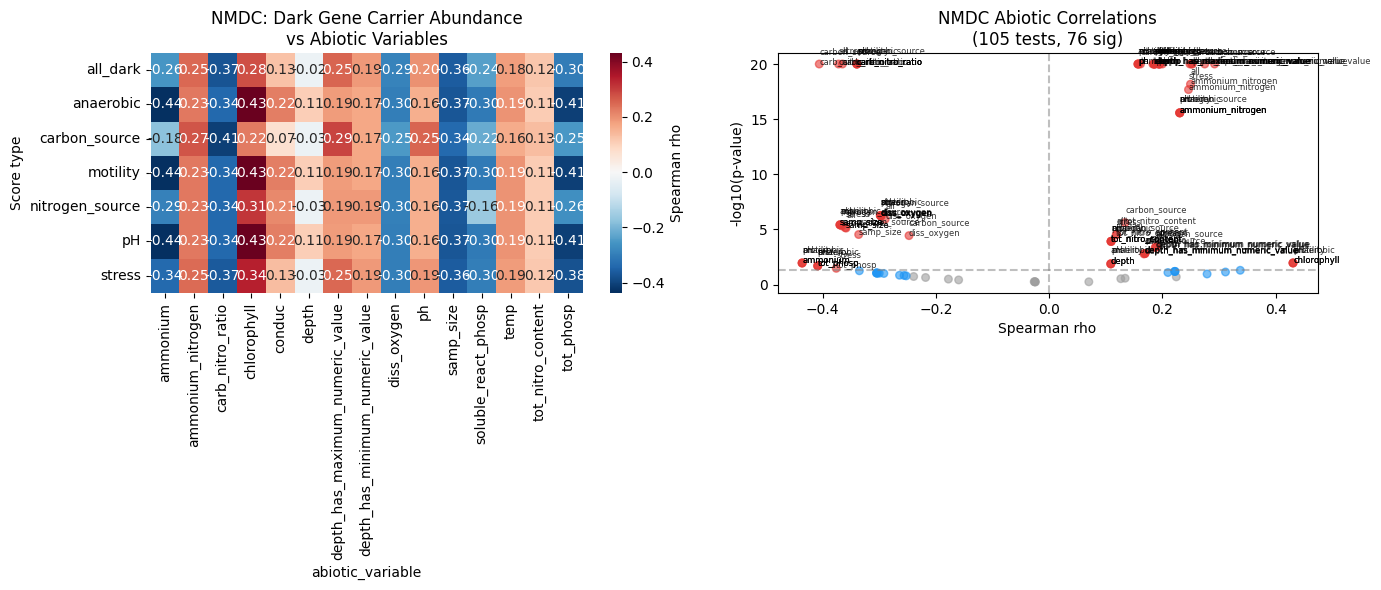

Saved fig12_nmdc_correlations.png


In [16]:
# Figure 12: NMDC correlation results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Heatmap of correlations (score_type x abiotic_variable)
ax = axes[0]
if len(nmdc_df) > 0:
    pivot = nmdc_df.pivot_table(index='score_type', columns='abiotic_variable',
                                values='spearman_rho', aggfunc='first')
    # Show only variables with at least one |rho| > 0.05
    strong_cols = pivot.columns[pivot.abs().max() > 0.05]
    if len(strong_cols) > 0 and len(pivot) > 0:
        pivot_sub = pivot[strong_cols]
        # Clean labels
        pivot_sub.index = [s.replace('score_', '').replace('dark_carrier_abundance', 'all_dark')
                           for s in pivot_sub.index]
        sns.heatmap(pivot_sub, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
                   ax=ax, cbar_kws={'label': 'Spearman rho'})
        ax.set_title('NMDC: Dark Gene Carrier Abundance\nvs Abiotic Variables')
        ax.set_ylabel('Score type')
    else:
        ax.text(0.5, 0.5, 'No strong correlations found', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title('NMDC Correlations')
else:
    ax.text(0.5, 0.5, 'No NMDC data available', ha='center', va='center',
            transform=ax.transAxes)

# Panel B: Volcano plot of NMDC correlations
ax = axes[1]
if len(nmdc_df) > 0:
    colors = ['#E53935' if f < 0.05 else '#2196F3' if f < 0.2 else '#9E9E9E'
              for f in nmdc_df['fdr']]
    ax.scatter(nmdc_df['spearman_rho'],
              -np.log10(nmdc_df['p_value'].clip(lower=1e-20)),
              c=colors, alpha=0.6, s=30)
    ax.axhline(-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Spearman rho')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title(f'NMDC Abiotic Correlations\n({len(nmdc_df)} tests, {(nmdc_df["fdr"] < 0.05).sum()} sig)')
    
    # Label significant points
    sig_points = nmdc_df[nmdc_df['fdr'] < 0.05]
    for _, r in sig_points.iterrows():
        ax.annotate(f"{r['score_type'].replace('score_', '').replace('dark_carrier_abundance', 'all')}\n{r['abiotic_variable']}",
                   (r['spearman_rho'], -np.log10(max(r['p_value'], 1e-20))),
                   fontsize=6, alpha=0.8)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig12_nmdc_correlations.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig12_nmdc_correlations.png')

## Section 4: Save Outputs and Summary

In [17]:
# Save results
conc_df.to_csv(os.path.join(DATA_DIR, 'lab_field_concordance.tsv'), sep='\t', index=False)
print(f'Saved lab_field_concordance.tsv: {len(conc_df)} clusters')

nmdc_df.to_csv(os.path.join(DATA_DIR, 'nmdc_validation.tsv'), sep='\t', index=False)
print(f'Saved nmdc_validation.tsv: {len(nmdc_df)} correlation tests')

Saved lab_field_concordance.tsv: 47 clusters
Saved nmdc_validation.tsv: 105 correlation tests


In [18]:
# Final summary
print('=' * 70)
print('NB04: LAB-FIELD CONCORDANCE & NMDC VALIDATION — SUMMARY')
print('=' * 70)

print(f'\n--- Lab-Field Concordance ---')
print(f'Pre-registered condition classes: {len(CONDITION_ENV_MAP)}')
print(f'Clusters tested: {len(conc_df)}')
if len(conc_df) > 0:
    n_conc = conc_df['is_concordant'].sum()
    n_sig = (conc_df['fdr'] < 0.05).sum()
    n_sig_conc = ((conc_df['fdr'] < 0.05) & conc_df['is_concordant']).sum()
    print(f'  Concordant: {n_conc}/{len(conc_df)} ({n_conc/len(conc_df)*100:.1f}%)')
    print(f'  Significant (FDR < 0.05): {n_sig}')
    print(f'  Significant + concordant: {n_sig_conc}')

print(f'\n--- NMDC Validation ---')
if len(nmdc_df) > 0:
    print(f'Samples with taxonomy + abiotic: {len(shared_samples)}')
    print(f'Matched genera in NMDC: {len(matched_cols)}')
    print(f'Correlation tests: {len(nmdc_df)}')
    n_nmdc_sig = (nmdc_df['fdr'] < 0.05).sum()
    print(f'  Significant (FDR < 0.05): {n_nmdc_sig}')
else:
    print('No NMDC correlations could be computed')

print(f'\nOutput files:')
for f in ['lab_field_concordance.tsv', 'nmdc_validation.tsv']:
    fp = os.path.join(DATA_DIR, f)
    if os.path.exists(fp):
        size_kb = os.path.getsize(fp) / 1024
        print(f'  {f}: {size_kb:.1f} KB')
print(f'\nFigures:')
for f in ['fig11_concordance_matrix.png', 'fig12_nmdc_correlations.png']:
    fp = os.path.join(FIG_DIR, f)
    if os.path.exists(fp):
        print(f'  {f}')

NB04: LAB-FIELD CONCORDANCE & NMDC VALIDATION — SUMMARY

--- Lab-Field Concordance ---
Pre-registered condition classes: 6
Clusters tested: 47
  Concordant: 29/47 (61.7%)
  Significant (FDR < 0.05): 1
  Significant + concordant: 0

--- NMDC Validation ---
Samples with taxonomy + abiotic: 6365
Matched genera in NMDC: 5
Correlation tests: 105
  Significant (FDR < 0.05): 76

Output files:
  lab_field_concordance.tsv: 12.0 KB
  nmdc_validation.tsv: 10.1 KB

Figures:
  fig11_concordance_matrix.png
  fig12_nmdc_correlations.png
